# RECONOCIMIENTO DE ROSTROS

Se quiere poder hacer una busqueda másiva de un rostro en todo el conjunto de imagenes de estudio y recuperar aquellas en las que aparece dicho rostro. Para ello se hará uso de la librería face recognition.

# 0. Importación de packages y constantes

In [2]:
import face_recognition as fc
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import Image

# Packages propios
from utils.graphdbmanipulation import ImagesGraphDB
from utils.imagesmanipulation import ImageHelper
from utils.analytics import AnalyticsHelper


In [3]:
# Rutas de interés
PATH_IMAGENES_A_ANALIZAR = "./resources/images/Movil-S21"
PATH_GML_FILE = "./outputs/graph_databases/graph_FACE_RECOG.gml"

# 1. Detección de rostros

In [ ]:
%matplotlib inline
img = cv2.imread("./resources/images/rostro_a_buscar.jpg",cv2.IMREAD_COLOR)
# Localizo la cara
face_loc = fc.face_locations(img)[0]

# Conversión a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Se dibuja el rectangulo
cv2.rectangle(img_rgb,(face_loc[3],face_loc[0]),(face_loc[1],face_loc[2]),(0,255,0),5)

# Se muestra inline
plt.imshow(img_rgb)
plt.show()


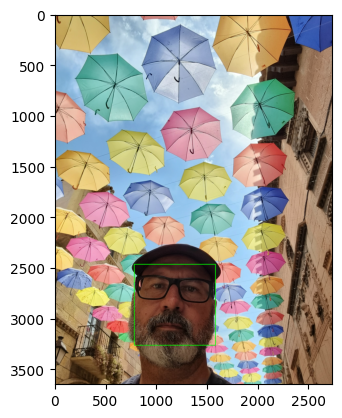

In [4]:
# Localizo la cara original que sirve de patrón de comparación
original_image = cv2.imread("./resources/images/rostro_a_buscar.jpg",cv2.IMREAD_COLOR)
face_loc_original = fc.face_locations(original_image)[0]
face_original_image_encodings = fc.face_encodings(original_image,known_face_locations=[face_loc_original])[0]

# Localizamos las caras de la imagen a comparar
image_to_compare = cv2.imread("./resources/images/imagen_test.jpg",cv2.IMREAD_COLOR)
face_locations = fc.face_locations(image_to_compare)
if face_locations != []:
    for face_location in face_locations:
        face_image_compared_encodings = fc.face_encodings(image_to_compare,known_face_locations=[face_location])[0]
        result = fc.compare_faces([face_image_compared_encodings],face_original_image_encodings)
        if result[0] == True:
            text = "Daniel"
            color = (0,255,0)
            locations = face_location
        else:
            text = "Desconocido"
            color = (255,0,0)
        cv2.rectangle(image_to_compare,(face_location[3],face_location[0]),(face_location[1],face_location[2]), color,5)
        cv2.putText(image_to_compare,text,(face_location[3],face_location[2]),2,3,(0,0,0),1)

img_to_compare_rgb = cv2.cvtColor(image_to_compare, cv2.COLOR_BGR2RGB)
plt.imshow(img_to_compare_rgb)
plt.show()


Se puede observar un reconocimiento positivo en otra imagen de test.

In [ ]:
# Se aplica la detección de rostros sobre todo el conjunto de imagenes
entries = os.listdir(PATH_IMAGENES_A_ANALIZAR)
images_analyzed_with_face_recognition=[]
imageHelper = ImageHelper()
# Localizo la cara original que sirve de patrón de comparación
portrait_image = cv2.imread('./resources/images/rostro_a_buscar.jpg', cv2.IMREAD_COLOR)
count=0
face_loc_original = fc.face_locations(portrait_image)[0]
face_original_image_encodings = fc.face_encodings(portrait_image, known_face_locations=[face_loc_original])[0]

for entry in entries:
    image_path = os.path.join(PATH_IMAGENES_A_ANALIZAR,entry)
    if not os.path.isfile(image_path):
        # Para saltar directorios
        continue
    result = imageHelper.face_recognition(face_original_image_encodings,image_path,0.5)
    print(f'{entry}:{result}')
    images_analyzed_with_face_recognition.append([entry,result[0],result[1],result[2],result[3],result[4]])

images_analyzed_results = pd.DataFrame(images_analyzed_with_face_recognition,columns=['filename','face_recognized','face_location_0','face_location_1','face_location_2','face_location_3'])

images_analyzed_results.to_csv('./outputs/intermediate_csv_files/face_recognition_data.csv')

In [4]:
# Se cargan los datos desde el csv generado anteriormente
images_analyzed_results = pd.read_csv('./outputs/intermediate_csv_files/face_recognition_data.csv')
images_analyzed_results.head(10)

,Unnamed: 0,filename,face_recognized,face_location_0,face_location_1,face_location_2,face_location_3
0,0,20210724_100218.jpg,False,0,0,0,0
1,1,20210724_104730.jpg,False,0,0,0,0
2,2,20210724_104736.jpg,False,0,0,0,0
3,3,20210724_104739.jpg,False,0,0,0,0
4,4,20210724_104743.jpg,False,0,0,0,0
5,5,20210724_104757.jpg,False,0,0,0,0
6,6,20210724_200143.jpg,True,511,2853,1469,1895
7,7,20210724_200145.jpg,True,405,2960,1363,2001
8,8,20210724_200231_02.jpg,True,869,2999,1668,2200
9,9,20210724_200231_03.jpg,True,781,2022,1579,1224


In [5]:
# Se carga información en grafo
imagesGraphDB = ImagesGraphDB()
# Añado un nodo de tipo persona
imagesGraphDB.add_node('Daniel')
imagesGraphDB.set_attribute_to_node('Daniel','type','person')
for row in images_analyzed_results.itertuples():
    if row.face_recognized == True:
         # Se crea el nodo de la imagen que contiene la persona detectada
         imagesGraphDB.add_node(row.filename)
         imagesGraphDB.set_attribute_to_node(row.filename,'type','image_filename')
         imagesGraphDB.add_edge(row.filename,'Daniel')
imagesGraphDB.write_gml_file(PATH_GML_FILE)


# 2. Análisis de resultados

In [6]:
# Se mira la cantidad de imágenes en que se ha encontrado el rostro propuesto
images_analyzed_results = pd.read_csv('./outputs/intermediate_csv_files/face_recognition_data.csv')
images_analyzed_results.groupby(['face_recognized']).size().reset_index(name='counts')

,face_recognized,counts
0,False,1185
1,True,180


In [8]:
# Se cargan las etiquetas manuales de las imágenes
df_images_labeled_manually = pd.read_excel('./resources/manual_labels/etiquetado_manual_imagenes.xlsx',skiprows=1)
df_images_labeled_manually.head(10)

,Image,Viaje,Comida,Cena,Cumpleaños,Retrato,Maria,Biel,Yo,Piscina,...,Tenedor,Cuchillo,Cuchara,bowl,pastel,silla,Mesa,Plato,Vaso,Llama vela
0,20210724_100218.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
1,20210724_104730.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20210724_104736.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,20210724_104739.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,20210724_104743.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,20210724_104757.jpg,0,0,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,20210724_200143.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
7,20210724_200145.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
8,20210724_200231_02.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
9,20210724_200231_03.jpg,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [9]:
# Se cargan las imágenes que contienen imagenes de retrato mios
df_images_me_analysis = df_images_labeled_manually[(df_images_labeled_manually['Yo'] == 1) & (df_images_labeled_manually['Retrato'] ==1)].copy()
# Se crea una nueva columna que indica que se ha detectado mi imagen en modo retrato
df_images_me_analysis['Me'] = 1
# Se cruza con el conjunto de imagenes total para dejar con NA las imagenes sin rostro detectado
df_images_me_analysis = df_images_labeled_manually.merge(df_images_me_analysis , how="left", left_on="Image", right_on="Image")

# Se informa con valor 0 aquellas imagenes sin detección de mi imágen
# en lugar de NA
df_images_me_analysis['Me'] = df_images_me_analysis['Me']. fillna(0)

# Se convierte a int la columna ya que se usa como booleano
df_images_me_analysis['Me'] = df_images_me_analysis['Me'].astype('int')

df_images_me_analysis

,Image,Viaje_x,Comida_x,Cena_x,Cumpleaños_x,Retrato_x,Maria_x,Biel _x,Yo_x,Piscina_x,...,Cuchillo_y,Cuchara_y,bowl_y,pastel_y,silla_y,Mesa_y,Plato_y,Vaso_y,Llama vela_y,Me
0,20210724_100218.jpg,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,20210724_104730.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,20210724_104736.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,20210724_104739.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,20210724_104743.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,IMG_20180505_212946_BURST001_COVER.jpg,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1361,IMG_20180505_212946_BURST002.jpg,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1362,IMG_20180505_212946_BURST003.jpg,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1363,IMG_20180822_173932.jpg,1,0,0,0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [10]:
# Se cargan los valores en el grafo
imagesGraphDB = ImagesGraphDB()
imagesGraphDB.load_graph_from_gml_file(PATH_GML_FILE)
# Se obtienen las imágenes del grafo
neighbors_me = imagesGraphDB.get_neighbours('Daniel')
# Se obtiene el dataframe de imágenes detectadas mediante el primer modelo
df_images_me_detected = pd.DataFrame(neighbors_me, columns=['Image'])
df_images_me_detected['Me predicted'] =1
# Se cruzan ambos dataframes
df_images_me_analysis = df_images_me_analysis.merge(df_images_me_detected , how="left", left_on="Image", right_on="Image")
# Se informa con valor 0 aquellas imagenes sin detección de rios y lagos
# en lugar de NA
df_images_me_analysis['Me predicted'] = df_images_me_analysis['Me predicted']. fillna(0)

# Se convierte a int la columna ya que se usa como booleano
df_images_me_analysis['Me predicted'] = df_images_me_analysis['Me predicted'].astype('int')

df_images_me_analysis

,Image,Viaje_x,Comida_x,Cena_x,Cumpleaños_x,Retrato_x,Maria_x,Biel _x,Yo_x,Piscina_x,...,Cuchara_y,bowl_y,pastel_y,silla_y,Mesa_y,Plato_y,Vaso_y,Llama vela_y,Me,Me predicted
0,20210724_100218.jpg,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,20210724_104730.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,20210724_104736.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,20210724_104739.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,20210724_104743.jpg,0,0,0,0,0,1,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,IMG_20180505_212946_BURST001_COVER.jpg,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1361,IMG_20180505_212946_BURST002.jpg,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1362,IMG_20180505_212946_BURST003.jpg,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1363,IMG_20180822_173932.jpg,1,0,0,0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [11]:
df_images_me_analysis[(df_images_me_analysis['Me'] == 0) & (df_images_me_analysis['Me predicted'] ==1)]

,Image,Viaje_x,Comida_x,Cena_x,Cumpleaños_x,Retrato_x,Maria_x,Biel _x,Yo_x,Piscina_x,...,Cuchara_y,bowl_y,pastel_y,silla_y,Mesa_y,Plato_y,Vaso_y,Llama vela_y,Me,Me predicted
44,20210725_181121.jpg,0,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
45,20210725_181125.jpg,0,0,0,0,0,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
130,20210731_152743.jpg,0,0,0,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
131,20210731_152805.jpg,0,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
132,20210731_152814.jpg,0,0,0,0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,20220731_132019.jpg,0,1,0,0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1075,20220822_130958.jpg,1,0,0,0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1076,20220822_131005.jpg,1,0,0,0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
1147,20220825_105858.jpg,1,0,0,0,1,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1


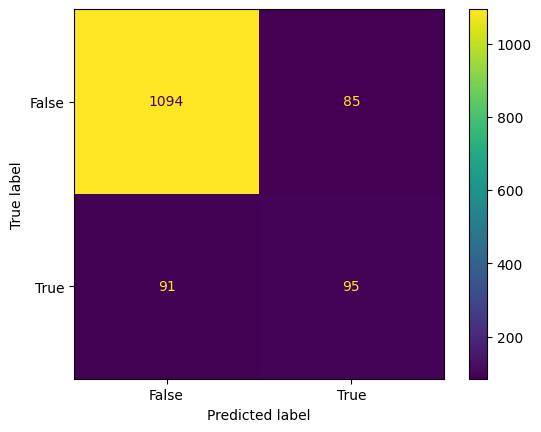

In [12]:
from sklearn import metrics

# Se cargan los resultados de la predicción y el real
images_me_actual= df_images_me_analysis['Me'].to_numpy()
images_me_predicted= df_images_me_analysis['Me predicted'].to_numpy()
# Se cargan los datos para generar la matriz de confusión
confusion_matrix = metrics.confusion_matrix(images_me_actual, images_me_predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
# Se muestra el gráfico
cm_display.plot()
plt.show()

In [13]:
analyticsHelper = AnalyticsHelper()
metrics = analyticsHelper.getBinaryClassificationConfusionMatrixMetrics(confusion_matrix)
metrics

{'recall': 0.510752688172043,
 'precision': 0.5277777777777778,
 'accuracy': 0.8710622710622711,
 'specificity': 0.9279050042408821,
 'f1_score': 0.5191256830601094}